In [1]:
import geopandas as gd
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as db
import folium
from shapely.geometry import LineString
import geoplot as gplt
import geoplot.crs as gcrs
plt.rcParams['figure.figsize'] = [40,30]
plt.rcParams['legend.title_fontsize'] = 'small'

In [2]:
pp=0
df_geo=gd.read_file('taxi_zones.shp')
df_nor=pd.read_csv('taxi-sample.csv')
con = db.connect('test.db')
cur = con.cursor()
cur1=con.cursor()
df_nor = pd.merge(df_nor, df_geo[['LocationID','borough','zone']], left_on='PULocationID', right_on='LocationID')
if pp == 1:
    df_nor['pickup_datetime'] = pd.to_datetime(df_nor['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
    df_nor['drop_datetime'] = pd.to_datetime(df_nor['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
    #del df_t['tpep_pickup_datetime']
    #del df_t['tpep_dropoff_datetime']
    df_nor.to_sql(name='taxi',if_exists='replace',con=con)

In [37]:

df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.representative_point().coords[:])
df_geo['coords'] = [coords[0] for coords in df_geo['coords']]
df_geo

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,coords,time_window,zero_trip_paid,avg_speed
0,1,0.116357,0.000782,162,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...","(935223.026585771, 190535.05257488793)",17,109.285763,0
1,2,0.433470,0.004866,162,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...","(1032515.6723034503, 167292.49319458753)",22,0.000000,0
2,3,0.084341,0.000314,162,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...","(1025882.734753933, 254779.60063055903)",9,100.300000,0
3,4,0.043567,0.000112,162,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...","(990618.795051066, 203105.53231811523)",8,18.226250,0
4,5,0.092146,0.000498,162,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...","(931467.962751084, 139837.47838920355)",12,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,162,259,Bronx,"POLYGON ((1025414.781960189 270986.1393638253,...","(1023962.1062603473, 266878.03401842713)",21,68.585000,0
259,260,0.133514,0.000422,162,260,Queens,"POLYGON ((1011466.966050446 216463.0052037984,...","(1010929.7151554413, 211369.88341673464)",9,19.254000,0
260,261,0.027120,0.000034,162,261,Manhattan,"POLYGON ((980555.2043112218 196138.486258477, ...","(980668.1871678794, 197575.6898618415)",15,29.792500,0
261,262,0.049064,0.000122,162,262,Manhattan,(POLYGON ((999804.7945504487 224498.5270484537...,"(999253.1085677049, 222193.81875760853)",6,33.037797,0


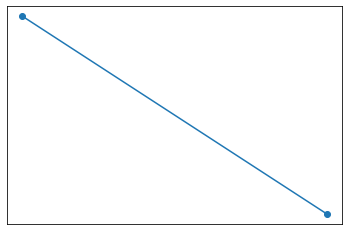

In [4]:
import matplotlib.pyplot as plt
waypoints = [[935223.026585771,1032515.6723034503], [190535.05257488793,167292.49319458753]]
plt.plot(waypoints[0], waypoints[1], 'o-')
plt.grid(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.show()

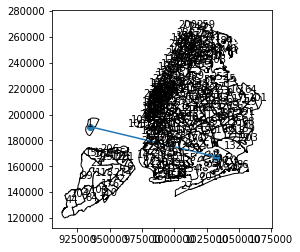

<Figure size 432x288 with 0 Axes>

In [5]:
cur.execute('''select MAX(total_amount),(select strftime('%H', pickup_datetime)),LocationID from taxi group by LocationID order by LocationID asc;''')
rows = cur.fetchall()

df_geo['time_window'] = 0
fig, ax = plt.subplots()
base = df_geo.plot(color='white', edgecolor='black',ax=ax)
for row in rows:
    df_geo.loc[df_geo['LocationID'] == row[2],'time_window'] = row[1]
df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.representative_point().coords[:])
df_geo['coords'] = [coords[0] for coords in df_geo['coords']]
for idx, row in df_geo.iterrows():
    plt.annotate(s=row['LocationID'], xy=row['coords'],
                 horizontalalignment='center')
waypoints = [[935223.026585771,1032515.6723034503], [190535.05257488793,167292.49319458753]]
plt.plot(waypoints[0], waypoints[1], 'o-')
#plt.grid(False)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.show()
df_geo['time_window'] = df_geo['time_window'].astype(int)
df_geo.plot(column='time_window', cmap='BrBG', legend=True, ax=base)
ax.set_title("Time for Highest Revenue", fontsize=42)
ax.set_axis_off()

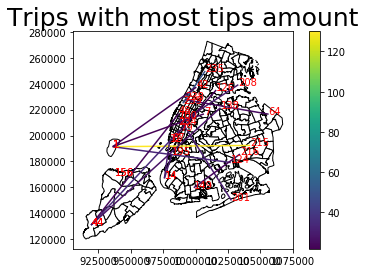

In [6]:
def trips_with_most_tips():
    fig, ax = plt.subplots(1,1)
    base = df_geo.plot(color='white', edgecolor='black',ax=ax)
    cur.execute(''' select avg(tip_amount) as amt, PULocationID, DOLocationID from taxi group by PUlocationID, DOLocationID order by amt DESC limit 20; ''')
    rows = cur.fetchall()
    lines = []
    tip_score=[]
    for row in rows:
        if row[1] > 263 or row[2] > 263:
            continue
        p = df_geo.loc[df_geo['LocationID'] == row[1]].centroid
        q = df_geo.loc[df_geo['LocationID'] == row[2]].centroid
        p = (p.x, p.y)
        q = (q.x, q.y)
        lines.append(LineString([p,q]))
        tip_score.append(row[0])
        base.annotate(row[1], p,color='red')
        base.annotate(row[2], q,color='red')
    trip_df = gd.GeoDataFrame({'geometry': lines,'tips_score':tip_score})
    trip_df.crs = {'init': 'epsg:2263'}
    trip_df = trip_df.to_crs(df_geo.crs)
    trip_df.plot(column='tips_score',ax=base, legend=True)
    ax.set_title('Trips with most tips amount', fontsize=25)
trips_with_most_tips()

In [7]:
from geopy.geocoders import Nominatim

point = '40.749403, -73.990841' #here's famous Sherlock Holmes' museum lat & lng
locator = Nominatim(user_agent='myGeocoder')
#location = locator.geocode('Champ de Mars, Paris, France')
location = locator.reverse(point)
location

Location(W 32 ST/7 AV, West 32nd Street, Herald Square, Manhattan Community Board 5, Manhattan, New York County, NYC, New York, 10001, USA, (40.7494061, -73.9909692, 0.0))

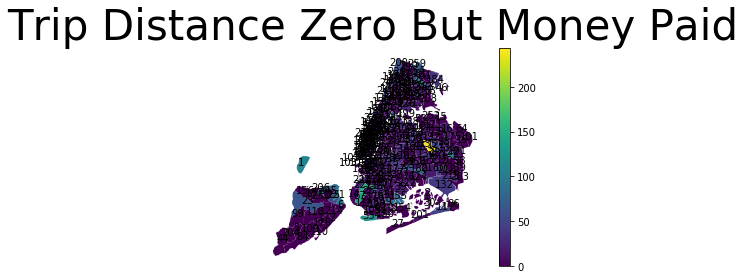

In [8]:
cur.execute('''select trip_distance,LocationID,avg(total_amount) from taxi where trip_distance=0 group by LocationID order by LocationID asc;''')
rows = cur.fetchall()
df_geo['zero_trip_paid'] = 0
fig, ax = plt.subplots()
for row in rows:
    df_geo.loc[df_geo['LocationID'] == row[1],'zero_trip_paid'] = row[2]
    
df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.representative_point().coords[:])
df_geo['coords'] = [coords[0] for coords in df_geo['coords']]
for idx, row in df_geo.iterrows():
    plt.annotate(s=row['LocationID'], xy=row['coords'],
                 horizontalalignment='center')
    
df_geo.plot(column='zero_trip_paid', cmap='viridis', legend=True, ax=ax)
ax.set_title("Trip Distance Zero But Money Paid", fontsize=42)
ax.set_axis_off()

In [29]:
cur.execute('''select avg_trip_distance/average_time_hrs, LocationId from taxi_norm where avg_trip_distance/average_time_hrs<100;''')

rows = cur.fetchall()

df_geo['avg_speed'] = 0

    

fig, ax = plt.subplots()
for row in rows:
    df_geo.loc[df_geo['LocationID'] == row[1],'avg_speed'] = row[0]

    
df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.representative_point().coords[:])
df_geo['coords'] = [coords[0] for coords in df_geo['coords']]
for idx, row in df_geo.iterrows():
    plt.annotate(s=row['LocationID'], xy=row['coords'],
                 horizontalalignment='center')

    
ax.set_title("Average Speed Of Taxis", fontsize=42)
ax.set_axis_off()

ValueError: Image size of 594195304x145214624 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x720 with 1 Axes>

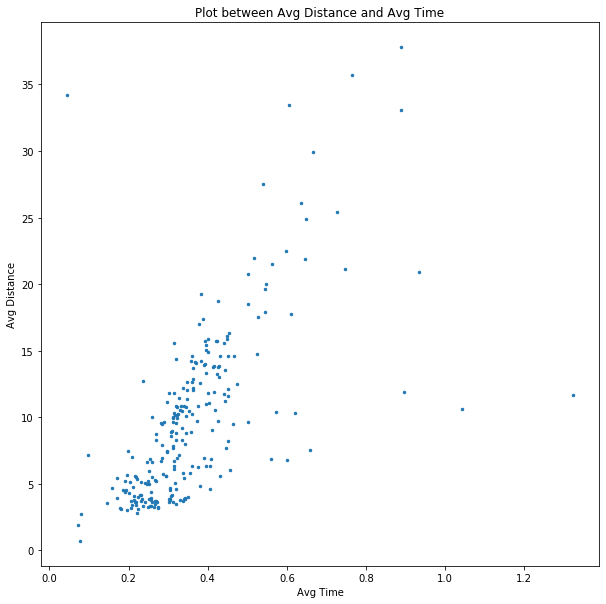

In [30]:
plt.rcParams['figure.figsize'] = [10,10]
cur1.execute('''select LocationID,average_time_hrs,avg_trip_distance from taxi_norm''')
rows1=cur1.fetchall()
fig, ax = plt.subplots()
df_geo['avg_speed'] = 0
df=pd.DataFrame(rows1)
df.columns=['LocationID','avg_time_hrs','avg_dist_kms']
plt.scatter(df['avg_time_hrs'],df['avg_dist_kms'],s=6)
plt.title("Plot between Avg Distance and Avg Time")
plt.xlabel("Avg Time")
plt.ylabel("Avg Distance")
plt.show()



In [11]:
#to add labels on scatter plot
#for i, txt in enumerate(df['LocationID']):
 #   ax.annotate(txt, (df['avg_time_hrs'][i],df['avg_dist_kms'][i]))
#plt.show()

IndexError: tuple index out of range

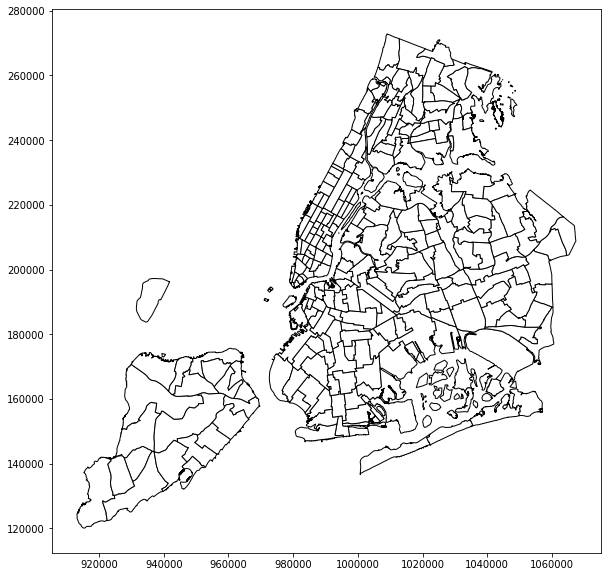

In [12]:
cur.execute('''select MAX(total_amount),LocationID from taxi group by LocationID order by total_amount desc limit 5;''')
rows = cur.fetchall()


fig, ax = plt.subplots()
base = df_geo.plot(color='white', edgecolor='black',ax=ax)
for row in rows:
    df_geo.loc[df_geo['LocationID'] == row[2],'time_window'] = row[1]
df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.representative_point().coords[:])
df_geo['coords'] = [coords[0] for coords in df_geo['coords']]
for idx, row in df_geo.iterrows():
    plt.annotate(s=row['LocationID'], xy=row['coords'],
                 horizontalalignment='center')
waypoints = [[935223.026585771,1032515.6723034503], [190535.05257488793,167292.49319458753]]
plt.plot(waypoints[0], waypoints[1], 'o-')
#plt.grid(False)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.show()
df_geo['time_window'] = df_geo['time_window'].astype(int)
df_geo.plot(column='time_window', cmap='BrBG', legend=True, ax=base)
ax.set_title("Time for Highest Revenue", fontsize=42)
ax.set_axis_off()


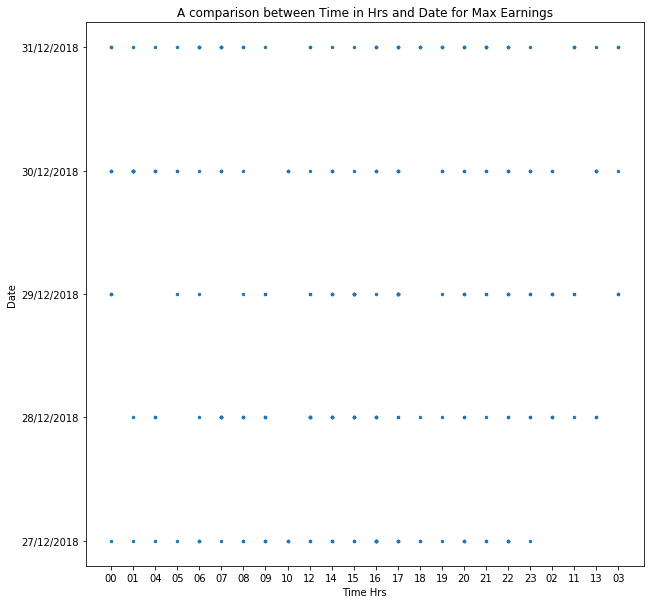

In [41]:
plt.rcParams['figure.figsize'] = [10,10]
cur.execute('''select MAX(total_amount),(select strftime('%H', pickup_datetime)),(select strftime('%d/%m/%Y', pickup_datetime)),LocationID from taxi group by LocationID order by pickup_datetime asc;''')
rows=cur.fetchall()
fig, ax = plt.subplots()
df=pd.DataFrame(rows)
df.columns=['max_total_amount','time_max','date_max','LocationID']
plt.scatter(df['time_max'],df['date_max'],s=6)
plt.title("A comparison between Time in Hrs and Date for Max Earnings")
plt.xlabel("Time Hrs")
plt.ylabel("Date")
plt.show()
